# Classification

Last week we learned about linear regression. It is clear that "linear" refers to a line, but what is "regression"? **Regression** is simply the process of predicting a continuous value. However, sometimes we want to predict a *categorical* value, such as dog vs cat vs mouse, or pass vs fail. Predicting a categorical value is refered to as **classification**.

### Imports

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

### Data loading

In this notebook we will work with data from an Internet Service Provider (ISP). It includes roughly 7000 (anonymized) customers. Below is a summary of the columns which may not be clear:
- **customerID:** A unique ID for each customer
- **Partner:** Whether or not the customer has a partner (spouse/significant other)
- **tenure:** How many months the person has been a customer
- **MonthlyCharges:** How much (in dollars) the customer is charged every month
- **TotalCharges:** How much the customer has been charged over their lifetime with the ISP
- **Churn:** Whether or not a customer leaves the ISP (i.e. cancels their service)

In [ ]:
df = pd.read_csv('data/isp_customers.csv')

In [ ]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Data cleaning

Let's start by looking for missing or unrealistic values.

In [ ]:
# Nothing missing
df.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [ ]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

Looking through the data types, we see that `TotalCharges` (money they've been charge in total) is an `object` (i.e. a string). That's bad, because we can't add, take averages, etc.

In [ ]:
# This doesn't work, a big error is coming...
df['TotalCharges'].mean()

TypeError: ignored

You can try to convert it to a `float` using `.astype(float`), however...

In [ ]:
# An error is coming...
df['TotalCharges'] = df['TotalCharges'].astype(float)

If you look at the error you'll see that there is a blank string `''` which Python doesn't know how to convert to a float. Pandas has a helper function `.to_numeric()` which can convert strings to numbers, and if you tell is `errors='coerce'` it will take values that it could not convert (like `''`, say, or `'apple'`) and make them into a `NaN`.

In [ ]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce') 

In [ ]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

In [ ]:
df.isna().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

So there were 11 rows with bad values. Let's just drop those.

In [ ]:
df = df.dropna(how='any')

Finally, we see that lots of columns have values of `Yes` and `No`. It's good to check that these are consistent. For example, sometimes a `yes` (notice the lowercase) will sneak in, or ` Yes` (notice the extra space). We'll do a quick check. We can use the Pandas helper function `.select_dtypes()` to only select columns of a certain data type.

In [ ]:
for c in df.select_dtypes(include='object').columns:
    # Just grab those columns with not too many different values
    if df[c].nunique() < 10:
        print(f'{c}: {df[c].unique()}')

gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn: ['No' 'Yes']


Everythign seems fine here, no weird casing, spaces, etc. Let's move on.

## Logistic regression <a id="logistic_regression"></a>

As discussed above, **regression** is the process of predicting a continuous value, while **classification** is the process of predicting a categorical value. Last week we worked with linear *regression*. This week we will start working with the analog on the classification side, namely, logistic regression.

Now you may have noticed, we just said we are doing *classification* with logistic *regression*. This may be confusing. However, logistic regression actually *is* a *regression* model, we just use it for the purposes of classification. Let's dive in.

Suppose we want to predict whether or not a customer will "churn" (cancel their service). This is a very common business question, and a common task for data analysts/scientists are companies. Note that we *cannot* directly use linear regression, because we're only predicting "Yes" or "No" for churn. Even if we were to do something like change "Yes" to 1 and "No" to 2, what if our linear regression model predicted a 3? Or 0.57? How should we interpret this? Rather than trying to force linear regression to work for our problem, let's instead change our approach.

Let's suppose we're trying to determine if a customer will churn (i.e. `Churn='Yes'`). While we *could* come up with a way to simply predict "Yes" or "No", this could be problematic. After all, what if the model was 99% sure that one customer would churn, and 51% sure that another would. It would have no way to communicate this to us if all it did was return "Yes" for both customers. Instead, what we want our model to do is return the *probability* of a customer churning. By doing so we can see exactly how confident our model's predictions are.

In order to do this, we first need a function which only returns values between 0 and 1. One such function which does this is called the **sigmoid function**, given by $\sigma(x) = \displaystyle\frac{1}{1+e^{-x}}$. Below is a plot of the sigmoid function:

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

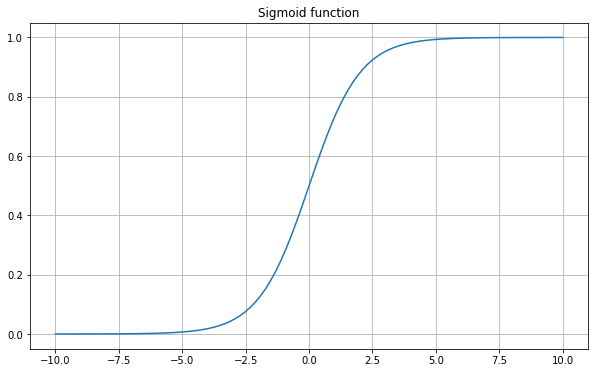

In [ ]:
# Print out x in a new cell to see what linspace does...
x = np.linspace(-10, 10, 100)

fig = plt.figure(figsize=(10, 6))
plt.plot(x, sigmoid(x))
plt.grid()
plt.title('Sigmoid function');

As you can see, this function always takes values between 0 and 1. You can see that by noting that $e^{-x} = \displaystyle\frac{1}{e^x}$ is always positive and takes values between 0 and infinity, and so the denominator takes values between 1 and infinity. Thus $\displaystyle\frac{1}{1 + e^{-x}}$ takes values between 0 and 1.

One thing to note is that we can change exactly how the sigmoid function looks based on what we feed into it. For example, what if we plotted $\sigma(2x)$, or $\sigma(-3x+1)$? Below are plots showing the results.

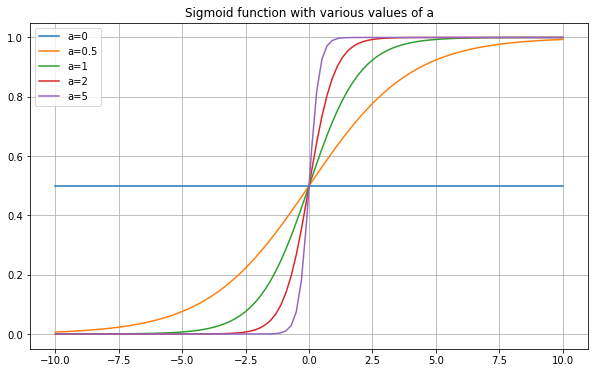

In [ ]:
fig = plt.figure(figsize=(10, 6))
plt.plot(x, sigmoid(0*x), label='a=0')
plt.plot(x, sigmoid(0.5*x), label='a=0.5')
plt.plot(x, sigmoid(x), label='a=1')
plt.plot(x, sigmoid(2*x), label='a=2')
plt.plot(x, sigmoid(5*x), label='a=5')
plt.legend()
plt.grid()
plt.title('Sigmoid function with various values of a');

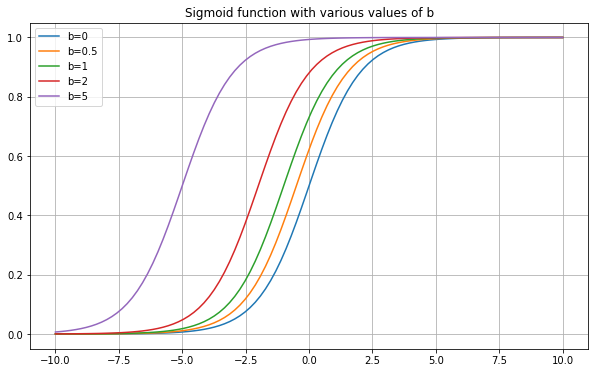

In [ ]:
fig = plt.figure(figsize=(10, 6))
plt.plot(x, sigmoid(x+0), label='b=0')
plt.plot(x, sigmoid(x+0.5), label='b=0.5')
plt.plot(x, sigmoid(x+1), label='b=1')
plt.plot(x, sigmoid(x+2), label='b=2')
plt.plot(x, sigmoid(x+5), label='b=5')
plt.legend()
plt.grid()
plt.title('Sigmoid function with various values of b');

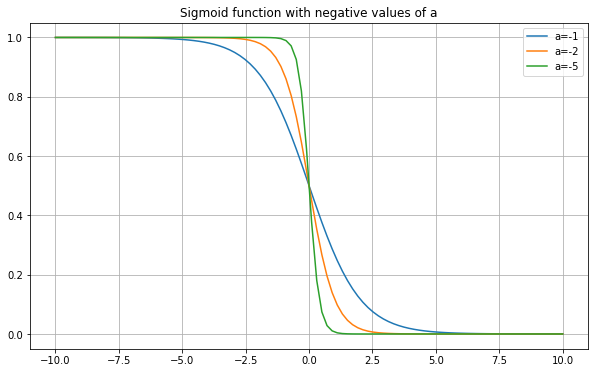

In [ ]:
fig = plt.figure(figsize=(10, 6))
plt.plot(x, sigmoid(-1*x), label='a=-1')
plt.plot(x, sigmoid(-2*x), label='a=-2')
plt.plot(x, sigmoid(-5*x), label='a=-5')
plt.legend()
plt.grid()
plt.title('Sigmoid function with negative values of a');

So making $a$ larger makes the graph "sharper" in the middle (i.e. a faster transition from 0 to 1), and making it closer to zero smooths it out. Making $a$ negative flips the graph. Making $b$ larger moves the graph to the left, and making it negative moves it to the right (this should all sound like manipulating any function $f(x)$). 

The question then is, what values of $a$ and $b$ will make the sigmoid best predict probabilities for churn? In fact, just like with linear regression, there is no reason we need only a single slope and y-intercept. We could have the logistic regression function with many variables:

$$
\sigma(m_1 x_1 + m_2 x_2 + \cdots + m_n x_n + b) = \displaystyle\frac{1}{1+e^{-m_1 x_1 - m_2 x_2 - \cdots - m_n x_n - b}}
$$

This is a completely valid function that makes its predictions based on a number of different variables. We could fit this model using gradient descent, exactly like linear regression did. **This is logistic regression**. Logistic regression is simply linear regression, but plugged into the sigmoid function to force the output to be between 0 and 1. Rather than coding it by hand, we will use sklearn's implementation of logistic regression. All of the steps should look very similar to how we did linear regression using sklearn. In the background, what sklearn is doing is predicting the probability of "Yes" vs "No". It then finds which has a higher probability, and returns that as the prediction. So while it *looks like* a classification model (in that it's predicting a categorical value of Yes/No), in actuality what is going on is regression (it is predicting a probability, a continuous value between 0 and 1). Let's take a look.

In [ ]:
from sklearn.linear_model import LogisticRegression

# It is common to use the variable name "clf" for "classifier". We discourage you from using "lr" for "logistic regression", as "lr" typically refers to "linear regression"
clf = LogisticRegression()

Since we need continuous values of $x_i$ for the above formula to make sense, we can only use continuous features to predict churn. We will use `TotalCharges` and `MonthlyCharges`.

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.3)

feat_cols = ['TotalCharges', 'MonthlyCharges']
target_col = 'Churn'

X_train = train_df[feat_cols]
y_train = train_df[target_col]

X_test = test_df[feat_cols]
y_test = test_df[target_col]

clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
test_pred = clf.predict(X_test)

for i in range(10):
    # We use [i] for test_pred because it's a list (actually a numpy array, basically the same thing)
    # We use .iloc[i] for y_test because it's a Pandas Series/DataFrame
    print(f'Predicted = {test_pred[i]}, Actual = {y_test.iloc[i]}')

Predicted = No, Actual = Yes
Predicted = No, Actual = No
Predicted = No, Actual = Yes
Predicted = No, Actual = No
Predicted = No, Actual = No
Predicted = No, Actual = No
Predicted = Yes, Actual = Yes
Predicted = No, Actual = No
Predicted = No, Actual = No
Predicted = No, Actual = Yes


We said above that sklearn is actually predicting probabilities. If you'd like to see what those probabilities are, you can use the `.predict_proba()` function. This returns a list, where the first number is the probability of the first class, and the second is the probability of the second class.

In [ ]:
test_pred_proba = clf.predict_proba(X_test)

for i in range(10):
    # We use [i] for test_pred because it's a list (actually a numpy array, basically the same thing)
    # We use .iloc[i] for y_test because it's a Pandas Series/DataFrame
    print(f'Predicted: P("No") = {test_pred_proba[i][0]:.3f}, P("Yes") = {test_pred_proba[i][1]:.3f}, Actual = {y_test.iloc[i]}')

Predicted: P("No") = 0.715, P("Yes") = 0.285, Actual = Yes
Predicted: P("No") = 0.791, P("Yes") = 0.209, Actual = No
Predicted: P("No") = 0.851, P("Yes") = 0.149, Actual = Yes
Predicted: P("No") = 0.859, P("Yes") = 0.141, Actual = No
Predicted: P("No") = 0.643, P("Yes") = 0.357, Actual = No
Predicted: P("No") = 0.641, P("Yes") = 0.359, Actual = No
Predicted: P("No") = 0.404, P("Yes") = 0.596, Actual = Yes
Predicted: P("No") = 0.941, P("Yes") = 0.059, Actual = No
Predicted: P("No") = 0.530, P("Yes") = 0.470, Actual = No
Predicted: P("No") = 0.866, P("Yes") = 0.134, Actual = Yes


Looking at the probabilities can be interesting, as you can see which rows it is highly confident in, and which it is unsure of. If you wanted to, you could write your own function which would not use 0.5 (50%) as the cutoff, but some other value.

We can see that overall our predictions mostly match the correct values. However, one interesting thing to note is that all of the predictions shown are "No". So did our model *ever* predict "Yes"? The easiest way to check this is to turn our predictions into a Pandas Series, and then use `value_counts()`.

In [ ]:
pd.Series(test_pred).value_counts()

No     1750
Yes     360
dtype: int64

So sure enough, it did. Let's go through all the predictions and count up what percentage are correct.

In [ ]:
correct = 0
for i in range(y_test.shape[0]):
    if test_pred[i] == y_test.iloc[i]:
        correct += 1
        
print(f'Correct {correct} times ({100 * correct / y_test.shape[0]:.2f}%)')

Correct 1645 times (77.96%)


So it predicted correctly about 78% of the time, not bad!

Except that's really not that great. You may think "why is 78% bad? If I were guessing randomly I could only guess correctly 50% of the time!" Of course this is true. However, let's look at the customer churn in the training set.

In [ ]:
train_df['Churn'].value_counts(normalize=True)

No     0.733442
Yes    0.266558
Name: Churn, dtype: float64

So about 73% of customers did not churn. So if I had a "model" which simply always predicted "No", it looks like (at least on the training set) I would be correct about 73% of the time. Let's see how that would work on the test set.

In [ ]:
correct = 0
for i in range(y_test.shape[0]):
    if 'No' == y_test.iloc[i]:
        correct += 1
        
print(f'Correct {correct} times ({100 * correct / y_test.shape[0]:.2f}%)')

Correct 1553 times (73.60%)


So our logistic model only moved us from 73.6% to 78%. So while a almost 6% increase (compute percentages the correct way: (new - old) / old = (77.96 - 73.6) / 73.6 = 5.92% improvement) is nothing to sneeze at, it's not nearly as good as it may seem at first glance.

## Loss functions for classification <a id="loss_classification"></a>

Earlier this semester we talked about that the way models are trained is by using gradient descent. More specifically, we pick a loss function which measures how good or bad our predictions are, and then keep adjusting our models parameters until that loss is as small as possible. For the case of regression, this loss function is generally mean squared error (MSE), which had the equation

$$
MSE = \displaystyle\sum_{i=1}^n (y_i - \hat{y_i})^2 
$$

where $y_i$ is the ground truth (correct value) and $\hat{y_i)$ is the predicted value. But what about for classification? Since we are taking the gradient of the loss function, we need it to be continuous and differentiable. Classification works with categories (either as text, such as "Yes" and "No") and integers (1, 2, 3, etc.). This makes it hard to make things differentiable. Therefore, we primarily work with the *probabilities* predicted. Most classification models don't just produce a prediction, they also predict the probability of an occurence. The loss function we will primarily use is called cross entropy. If there are just two classes we are predicting (Yes/No, 0/1, etc.) then this is called binary cross entropy, and has the following form:

$$
BCE = -\frac{1}{n}\displaystyle\sum_{i=1}^n (y_i \log(\hat{y_i}) + (1-y_i)\log(1-\hat{y_i}))
$$

It's beyond the scope of this course to dive into the mathematics of this, but the primary idea is that binary cross entropy measures how similar $y$ and $\hat{y}$ are. In cases where there are more than two classes, we instead use the loss function cross entropy (note that it is no longer "binary"), which has the form

$$
CE = -\frac{1}{n}\displaystyle\sum_{i=1}^n \displaystyle\sum_{c=1}^C c_i \log(\hat{c_i})
$$

where $C$ is the number of classes and $c_i$ is the probability of the $i$'th sample being in class $c$.

## Classification metrics <a id="classification_metrics"></a>

As the previous section hinted at, "accuracy" is not always the best metric. For example, consider the following problem: You work for a biomedical company and want to develop a test to predict whether or not a patient has a certain disease. You look through the data and see that roughly 0.04% of the population has this disease. Therefore, by creating a "test" which says "No, you don't have the disease", you would be right (i.e. accurate) 99.96% of the time!

Our goal then is to come up with other metrics besides accuracy which help us determine how good our model is. Below are several such metrics.

### Weighted accuracy <a id="weighted_accuracy"></a>

The simplest improvement we can make is to "weight" our classes differently. For example, since we see that 70%+ of the ISP customers do not churn, the ISP is probably more interested in being correct on customers who *will* churn. For example, suppose the company looks for customers predicted to churn, and reaches out to them to say "thank you for being a customer, here is a \$5 gift card". If the model was correct and the customer really was ready to leave (churn), then maybe this intervention will make them stay. And if the model was wrong and the customer was not planning to churn, then the company is only out \$5, and the customer is very happy! So being correct on the churning customers is more important than on the non-churning customers. Therefore, we could consider the following change: Give predictions a value of (say) 0.2 if the prediction is that they won't churn, and a value of 0.7 if the prediction is that they will churn. That way, correct predictions for churn are given more "weight", and incorrect predictions for churn are penalized more heavily as well.

Let's do this now.

In [ ]:
def weighted_accuracy(y, y_pred, weights):
    correct_weighted = 0
    for i in range(y.shape[0]):
        if y_pred[i] == y.iloc[i]:
            correct_weighted += weights[y_pred[i]]

    print(f'Weighted accuracy: {100 * correct_weighted / y.shape[0]:.2f}%')

In [ ]:
weights = {'Yes': 0.2, 'No': 0.7}
weighted_accuracy(y_test, test_pred, weights)

Weighted accuracy: 49.22%


In [ ]:
# Giving both a weight of 1 is just accuracy, and so we get the exact same value
weights = {'Yes': 1, 'No': 1}
weighted_accuracy(y_test, test_pred, weights)

Weighted accuracy: 77.96%


Thus our weighted accuracy is much lower. Note that weighted accuracy requires you to (essentially randomly) choose the weights for each category. This is problematic, because your results depend heavily on these values.

### Precision and Recall <a id="precision_recall"></a>

In accuracy, predicting "Yes" or "No" both received the same "weight". We could fix this in weighted accuracy by assigning weights, but those weights were essentially arbitrary. Really what we want is to focus on the customers who actually will churn (i.e. the ground truth for `Churn` is "Yes"). What we can do is compute the following: Out of the customers who we *predicted* will churn, what percentage of those *actually did* churn? In other words, what is the **precision** of our model. Written as an equation, this becomes:

$$
\text{Precision} = \frac{\text{predicted positive}}{\text{true positive} + \text{false positive}}
$$

where **true positive** means a positive prediction (Churn = "Yes" in our case) which is correct (the customer actually did churn), and **false positive** means a positive prediction (Churn = "Yes") which was wrong (the customer *did not* churn). 

Note that what precision is doing is focusing on the *model predictions* and see what percentage of positive predictions were correct. What if we did this the other way? That is, what if we instead focused on the *ground truth* and saw how our *model* did? In other words, what if we computed the following: Out of the customers who *actually did* churn, what percentage did we *predict* will churn? Notice that this is exactly the reverse of precision. The name for this metric is **recall**, also called the **true positive rate**. In equation form this becomes:

$$
\text{Recall} = \frac{\text{predicted positive}}{\text{true positive}}
$$

Thankfully, we do not need to compute all of these metrics by hand. Sklearn has helper functions built in for these. In particular, there is one especially helpful function called the classification report, illustrated below.

In [ ]:
from sklearn.metrics import classification_report

# Classification_report wants the correct labels first, followed by the predictions.
# You should always use print to display it, otherwise it will look bad
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

          No       0.81      0.91      0.86      1553
         Yes       0.63      0.41      0.49       557

    accuracy                           0.78      2110
   macro avg       0.72      0.66      0.68      2110
weighted avg       0.76      0.78      0.76      2110



Let's step through this. We don't know all of the components yet, but we can get a good start.

First the classification report is broken by what Churn: "Yes" vs "No". We said the ISP probably cares more about "Yes" churns, so we'll look at that row. 
**Precision:**
We see that the precision is 63%, meaning that out of the customers we *predicted* will churn, 63% of them actually did. To see the same thing for customers who didn't churn you can look at the "No" row. There the precision is 81%, so of customers that we predicted will *not* churn, 81% indeed did not.

**Recall:**
We see that for "Yes" churns, the recall is 41%, meaning that out of the customers who *actually did* churn, only 41% of them did we *predict* would churn. Similarly, for the "No" churn, see that out of the customers who *actually did not* churn, our model predicted 91% of them correctly.

**Support:**
Support is simply how many samples fit into each group. So for instance, 1,553 samples (rows) had customers who didn't churn, and 557 had customers who did churn.

**Accuracy:**
In the third row we see an overall accuracy on 78%, which is the same result we got above when we computed accuracy by hand.

### F1-score <a id="f1_score"></a>

Finally, we will discuss f1-score. Notice that precision considers actual positives (customers who really did churn, say) and finds what percentage our model could correctly predict. So precision rewards our model for being correct on the positive samples, even if it makes mistakes on the negative samples. Recall, on the other hand, looks at model positive predictions and finds what percentage of them are correct. So recall rewards our model for finding as many of the positive samples as possible. Ideally we want both of these to be true. We want our model to be strong on the positive samples, and we also want it to find as many positive samples as possible. In other to measure both of these at once, we can take a sort of average. In fact, we take the harmonic mean rather than the normal mean that you're used to. For an interesting article on various types of means, check out [this article](https://towardsdatascience.com/on-average-youre-using-the-wrong-average-geometric-harmonic-means-in-data-analysis-2a703e21ea0).

Regardless of the details, f1-score can be thought of as a type of average of precision and recall. It takes values between 0 and 1 (like precision, recall and accuracy), but it does not have a simple one sentence explanation like these others do. Regardless, if one model has a higher f1-score then another model, then it is likely that that model is "better" (in some sense) than the model with a lower f1-score. 

We see that our model has an f1-score of 86% for the non-churning customers, and 49% for the churning customers.

## Imbalanced data <a id="imbalanced_data"></a>

The underlying reason that we need to do all these fancy metrics is to deal with unbalanced data. By **unbalanced data** we just mean data where the label we are predicting (so classification) is not evenly distributed, meaning there are more of one label than another. This is extremely common, and in fact more common than balanced data. We gave the medical researcher example above, but unbalanced data appears everywhere. Most customers *don't* cancel their internet, so most don't churn, so that data is unbalanced. Suppose you were working at a company developing a model for predicting if your company's advertising will lead customers to make a purchase. Most people who see an ad don't go out and make a purchase for that product. Therefore that data is also unbalanced. 

### Undersampling <a id="undersampling"></a>
Note that the metrics above still don't address the underlying problem: our model is trained on unbalanced data, and so it learns that one class is far more likely to occur than the other. That means the model will "prefer" to predict the dominant class, even when there is evidence suggesting it should predict the other class. There is no one single method to fix this. However, two very common and powerful techniques are to undersample or oversample your data. By **undersampling** we mean picking your data so that the number of samples in both classes are the same. For instance, let's look at the training data.

In [ ]:
train_df['Churn'].value_counts()

No     3613
Yes    1309
Name: Churn, dtype: int64

We see there are 3613 non-churning customers, and 1309 who churned. We want both classes to have the same number of samples from each class. Since we can't magically make more churning customers, instead what we'll do is pick only 1309 non-churning customers (out of the 3613 available) and use just those. We can do this most easily using the Pandas `.sample()` function. If you give it an integer it will select that many rows from your data (you can also give it a number between 0 and 1 to select that *percentage* of your data).

In [ ]:
# Get only the customers who did not churn
train_no_df = train_df[train_df['Churn'] == 'No']
# Then select 1309 of them to match the 1309 "Yes" churn customers
train_no_df = train_no_df.sample(1309)

# Also grab the churning customers
train_yes_df = train_df[train_df['Churn'] == 'Yes']

# And now stick both DataFrames together to make a new undersampled training set
train_under_df = pd.concat([train_no_df, train_yes_df])

If we now compare the number of churn vs non-churn customers in the training set, we should see that they are equal.

In [ ]:
train_under_df['Churn'].value_counts()

Yes    1309
No     1309
Name: Churn, dtype: int64

Let's now use this new undersampled training data to train our model.

In [ ]:
# Copied the same columns that we used earlier
feat_cols = ['TotalCharges', 'MonthlyCharges']
target_col = 'Churn'

X_train_under = train_under_df[feat_cols]
y_train_under = train_under_df[target_col]

clf_under = LogisticRegression()
clf_under.fit(X_train_under, y_train_under)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Even though we undersampled our training data, **you should always test your model on the original unaltered data.** This is because the (imbalanced) data is the real data that you want your model to perform well on. If we were to also undersample our test set, we would be evaluating our model on data that looks totally different from the (imbalanced) problem we are trying to solve. So long story short, keep your test data untouched.

In [ ]:
test_pred_under = clf_under.predict(X_test)

print(classification_report(y_test, test_pred_under))

              precision    recall  f1-score   support

          No       0.88      0.72      0.79      1543
         Yes       0.49      0.73      0.58       567

    accuracy                           0.72      2110
   macro avg       0.68      0.72      0.69      2110
weighted avg       0.77      0.72      0.74      2110



For easy comparison, I've put the classification report for the original (*not* undersampled) data below:

In [ ]:
from sklearn.metrics import classification_report

# Classification_report wants the correct labels first, followed by the predictions.
# You should always use print to display it, otherwise it will look bad
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

          No       0.82      0.90      0.86      1543
         Yes       0.64      0.46      0.53       567

    accuracy                           0.78      2110
   macro avg       0.73      0.68      0.70      2110
weighted avg       0.77      0.78      0.77      2110



There are some interesting results. First, our overall accuracy dropped from 78% to 72%. However, as we discussed earlier, when dealing with imbalanced data accuracy is a flawed metric. Our precision is higher for the "No" churns, and lower for the "Yes" churns compared to the model trained on the original data. In the model trained on the original data, the recall was wildly different (90% vs 46%) on the "Yes" vs "No" churns. In our new model that was smoothed out, and now both are very similar. Similarly, the f1-score's got closer together (one up, one down) on our model trained on undersampled data.

Is this new model better? The answer is, "it depends". When developing a model, you always need to consider the use-case. Companies don't simply get bored and say "go build a model and make sure it's good". They have a *reason* for using the model. They want to stop customers from churning. They want to identify customers who may churn. They want to understand what makes one customer churn and one not. Each of these use cases might be better served by a different model. For example, the undersampled model having recall which is close together means that if we select a random customer, we can be more confident that our model will predict something useful about their churning. In the original model, 90% of customers who did not churn would be predicted correctly by our model, but only 46% of customers who will churn. That's a problem, because if you look at a random customer, you have no idea if they will churn or not. So even though the undersampled model has a lower recall for "No", the tradeoff is likely worth it. On the other hand, the precision in our original model was very good. Recall that a precision of 64% for "No" means that if you take all customers our model predicted will not churn, then 64% of those indeed will not churn. This is compared to only 49% for our undersampled model. Finally, since f1-score is a sort of average of precision and recall, we see that the undersampled model also strikes a (slightly) better balance in its performance in both the "No" and "Yes" class, as opposed to the original model, which performed stronger on the "No" class but worse on the "Yes" class.

### Oversampling <a id="oversampling"></a>

If undersampling is choosing rows so that both classes have the same number of samples as the minority class, then **oversampling** is choosing rows so that both classes have the same number of samples as the majority class. This may seem confusing, since by definition the minority class has less samples than the majority class. So how is it possible to then "choose more of them"? The answer is you choose them *with replacement*. Therefore, samples from the minority class will show up several times. This is in essence "duplicating the customers" in the minority class. You can sample with replacement using `.sample(replace=True)`. We'll follow the same process as with undersampling.

In [ ]:
train_df['Churn'].value_counts()

No     3620
Yes    1302
Name: Churn, dtype: int64

In [ ]:
# Get only the customers who did not churn
train_yes_df = train_df[train_df['Churn'] == 'Yes']
# Then select 3620 of them to match the 3620 "No" churn customers
train_yes_df = train_yes_df.sample(3620, replace=True)

# Also grab the churning customers
train_no_df = train_df[train_df['Churn'] == 'No']

# And now stick both DataFrames together to make a new undersampled training set
train_over_df = pd.concat([train_no_df, train_yes_df])

Once again, we now see that the number of samples in each class are the same.

In [ ]:
train_over_df['Churn'].value_counts()

No     3620
Yes    3620
Name: Churn, dtype: int64

Let's now train a logistic regression model with this oversampled data and compare our results.

In [ ]:
# Copied the same columns that we used earlier
feat_cols = ['TotalCharges', 'MonthlyCharges']
target_col = 'Churn'

X_train_over = train_over_df[feat_cols]
y_train_over = train_over_df[target_col]

clf_over = LogisticRegression()
clf_over.fit(X_train_over, y_train_over)

test_pred_over = clf_over.predict(X_test)

Let's now put all three classification reports together:

**Original data**

In [ ]:
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

          No       0.82      0.90      0.86      1543
         Yes       0.64      0.46      0.53       567

    accuracy                           0.78      2110
   macro avg       0.73      0.68      0.70      2110
weighted avg       0.77      0.78      0.77      2110



**Undersampled**

In [ ]:
print(classification_report(y_test, test_pred_under))

              precision    recall  f1-score   support

          No       0.88      0.72      0.79      1543
         Yes       0.49      0.73      0.58       567

    accuracy                           0.72      2110
   macro avg       0.68      0.72      0.69      2110
weighted avg       0.77      0.72      0.74      2110



**Oversampled**

In [ ]:
print(classification_report(y_test, test_pred_over))

              precision    recall  f1-score   support

          No       0.88      0.72      0.79      1543
         Yes       0.49      0.73      0.59       567

    accuracy                           0.72      2110
   macro avg       0.68      0.73      0.69      2110
weighted avg       0.77      0.72      0.74      2110



Let's once more go through what we see from each metric:

**Accuracy:** Nothing. Don't rely on accuracy for imbalanced data.
**Precision:** Precision is identical between the under and oversampled models. As discussed earlier, precision is showing what percentage of our predicted Yes/No actually were Yes/No. So the under and oversampled models did poorly with "Yes" predictions, but better with "No" predictions. That is, if we took a customer who our under/oversampled model predicted would churn (so a "Yes"), then only 49% of the time would they actually churn (that's bad). However, our "No" predictions are much better.
**Recall:** Again, recall is identical between the under and oversampled models. Recall tells us what percentage of the *actual* Yes/No churn customers our model predicted correctly. So our under/oversampled models were more balanced in their ability to find churning/non-churning customers, at the expense of losing some recall in the "No" class.
**F1-Score:** While there is a very slight difference in F1-score between the under and oversampled models, they are essentially the same. We see the same pattern of the under/oversampled models striking a better balance between the Yes/No classes than the model trained on the original data.

## Exercises

1. Pick a different categorical column (besides `Churn`) and predict it using logitistic regression
2. In this notebook we discuss how the sigmoid function is used to give values between 0 and 1. Another similar function is $\tanh(x)$, which gives values between -1 and 1. How could you change the $\tanh$ function to instead give values between 0 and 1?
3. Pick one of our previous datasets and use logistic regression to model a categorical variable. Go through the same discussion about which models are best/worst.